<a href="https://colab.research.google.com/github/VladMattiussi/DeepLearning/blob/main/RL_Alghoritms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors
The authors of this code, this notebook and its documentation are [Lorenzo Gardini](mailto: lorenzo.gardini7@studio.unibo.it) and [Vlad Mattiussi](mailto: vlad.mattiussi@studio.unibo.it).

# **Progetto DeepLearning**

## **Project goals**
Lo scopo del progetto è quello di studiare, addestrare e comparare algoritmi di Reinforcement Learning applicati al gioco Pong dell'Atari (https://en.wikipedia.org/wiki/Pong). Gli algoritmi utilizzati sono PPO, A2C e DQN con aggiunte per migliorarne le prestazioni (Dueling DQN, Prioritized Experience Replay, Double DQN).

## **Pong**
Pong è un videogioco bidimensionale che simula il ping-pong. I due giocatori possono muovere la rispettiva racchetta (simulata da una barra bianca) che può muovere verticalmente lungo un lato dello schermo per colpire la pallina (simulata da un piccolo quadrato) per rispedirla indietro. Se la pallina supera la racchetta di un giocatore il suo avversario guadagna un punto. Il primo giocatore che raggiunge 21 punti vince la partita. La palla si muove con velocità costante e può rimbalzare sui lati superiore e inferiore dello schermo.

<p align="center">
  <img src="https://miro.medium.com/max/320/1*P4l2XZUffcJfJQjQ125wSw.gif" width="300"/>
</p>

## **Installazione librerie**
- stable-baselines3 è una libreria open source di reinforcement learning. Da questa utiliziamo dei wrapper per l'environment.
- ale-py serve per i permessi con i giochi dell'Atari.

In [ ]:
%%capture
!pip install stable-baselines3[extra]
!pip install ale-py==0.7.4

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time
import statistics
import cv2
import uuid
from base64 import b64encode
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
from skimage import transform
from skimage.color import rgb2gray
from gym import spaces
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv, EpisodicLifeEnv
from abc import abstractmethod, ABC
import pandas as pd
import pickle
import math
from glob import glob

## Utility

- `print_episode_info`: stampa lo stato corrente dell'apprendimento della rete. 
- `save_model`: salva il modello (`dqn_action_model`, `dqn_target_model`, `train_rewards`, `epsilon`, `beta`, `replay_memory`) nel `path` specificato
- `load_model`: carica il modello (`dqn_action_model`, `dqn_target_model`, `train_rewards`, `epsilon`, `beta`, `replay_memory`) dal `path` specificato per riprendere l'addestramento 

In [ ]:
def print_episode_info(episode_number, 
                       step_count, 
                       train_step_count, 
                       episode_start_epsilon, 
                       epsilon,
                       episode_start_beta,
                       beta,
                       episode_elapsed_time,
                       episode_avg_step_time,
                       episode_reward,
                       moving_avg_reward):
  print(f'Episode: {episode_number} Steps: {step_count}[{train_step_count}]',
        f'Epsilon: [{episode_start_epsilon:.3f}->{epsilon:.3f}]',
        f'Beta: [{episode_start_beta:.3f}->{beta:.3f}]',
        f'Time: {episode_elapsed_time:.1f}s[{episode_avg_step_time:.2f}s]',  
        f'Total reward: {episode_reward}[{moving_avg_reward:.1f}]')
  
def save_model(path,
               dqn_action_model, 
               dqn_target_model, 
               train_rewards, 
               epsilon, 
               beta, 
               replay_memory):
  print('saving...')
  dynamic_path = lambda x: path + '/' + x
  dqn_action_model.save(dynamic_path('dqn_action_model')) 
  dqn_target_model.save(dynamic_path('dqn_target_model'))
  pd.Series(train_rewards).to_csv(dynamic_path('train_rewards.csv'), index=False)
  other_data = {
      'beta':beta,
      'epsilon':epsilon,
      'replay_memory':replay_memory
  }
  with open(dynamic_path('other_data.bin'), 'wb+') as data:
    pickle.dump(other_data, data)
  print('saved!')

def load_model(path):
  try:
    data = {}
    data['dqn_action_model'] = keras.models.load_model(path + '/dqn_action_model')
    data['dqn_target_model'] = keras.models.load_model(path + '/dqn_target_model')
    data['train_rewards'] = list(pd.read_csv(path + '/train_rewards.csv', squeeze=True, dtype=np.int8))
    with open(path + '/other_data.bin', 'rb') as other_data:
      data.update(pickle.load(other_data))
    print('previous data loaded')
    return data
  except Exception as e:
    print(f"ERROR: {e}")
    print('Data not loaded')
    return {}

## Specifiche dell'environment


Come environment per l'addestramento abbiamo usato la libreria Gym di Open AI (https://www.gymlibrary.dev/environments/atari/pong/#pong). In questa versione di pong la racchetta sinistra è controllata dal computer mentre la racchetta destra può essere mossa manualmente. Sarà proprio questa racchetta che verrà controllata dagli algoritmi. Le azioni   possibili che si possono effettuare sono:

In [ ]:
env_name = 'ALE/Pong-v5'
env = gym.make(env_name)

Di seguito le azioni possibili in gioco e il loro significati

In [ ]:
list(enumerate(env.get_action_meanings()))

le dimensioni dello spazio dell'environment (le dimensioni del tensore restituito)

In [ ]:
env.observation_space.shape

I valori minimi e massimi possibili per le osservazioni (essendo un'immagine RGB i valori sono quelli dei pixel per ogni colore)

In [ ]:
env.observation_space.low
env.observation_space.high

## Environment preprocessing


In questa parte viene effettuato il preprocessing dell'environment. Questo viene fatto per migliorare e stabilizzare l'apprendimento della rete. Le varie trasformazioni che vengono applicati all'env sono:
- `FrameStack`: prende in ingresso `k` che corrisponde quanti frame impilare per dare alla rete il senso del movimento. L'ultimo stato (quindi lo stato corrente) si trova alla k-esima posizione del tensore.
- `StickyActionEnv`: con una probabilità di `action_repeat_probability` l'environment ignora l'azione da eseguire e ripete la precedente azione. Questo permette alla rete (anche con un ϵ molto basso) di mantenere la rete stocastica e più imprevedibile in modo da migliorare l'addestramento (https://arxiv.org/pdf/1709.06009.pdf)
- `PreprocessImage`: preprocessa le immagini in modo da ridurre la complessità e ridurre il tempo d'addestramento. L' immagine viene tagliata usando i crops specificati con `crops` che corrisponde ad una tupla (top_crop, right_crop, bottom_crop, left_crop) e poi ridimensionata con le dimensioni specificati `shape` (width, height)
- `MaxAndSkipEnv`: Skippa `skip` frames (per accellerare l'apprendimento) ed effettua il max applicato a 2 frame consecutivi. Le vecchie console Atari utilizzavano la proprietà di decadimento lento dei fosfofori (che scintillano lo schermo) utilizzando 2 fotogrammi successivi per visualizzare completamente un oggetto. Quindi un singolo frame potrebbe non contenere le informazioni complete e fare max su 2 frame successivi in qualsiasi momento avrà le informazioni complete per la rete.


In [ ]:
class FrameStack(gym.Wrapper):
  def __init__(self, env, k):
    super().__init__(env)
    self.k = k
    self.frames = deque([], maxlen=k)
    shp = (*env.observation_space.shape, k)
    self.observation_space = spaces.Box(low=0, high=255, shape=shp, dtype=env.observation_space.dtype)

  def reset(self):
    ob = self.env.reset()
    for _ in range(self.k):
        self.frames.append(ob)
    return self._get_ob()

  def step(self, action):
    ob, reward, done, info = self.env.step(action)
    self.frames.append(ob)
    return self._get_ob(), reward, done, info

  def _get_ob(self):
    assert len(self.frames) == self.k
    return np.stack(self.frames, axis=2)


class StickyActionEnv(gym.Wrapper):
  def __init__(self, env: gym.Env, action_repeat_probability: float) -> None:
    super().__init__(env)
    self.action_repeat_probability = action_repeat_probability

  def reset(self, **kwargs):
    self._sticky_action = 0  # NOOP
    return self.env.reset(**kwargs)

  def step(self, action: int):
    if self.np_random.random() >= self.action_repeat_probability:
      self._sticky_action = action
    return self.env.step(self._sticky_action)

class PreprocessImage(gym.ObservationWrapper):
  def __init__(self, env: gym.Env, shape=(84,84), crops=(None, None, None, None)) -> None:
    super().__init__(env)
    self.shape = shape
    self.crops = crops
    self.observation_space = spaces.Box(
        low=0, high=255, shape=shape, dtype=env.observation_space.dtype
    )

  def observation(self, frame: np.ndarray) -> np.ndarray:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    height, width = frame.shape
    top_crop, right_crop, bottom_crop, left_crop = self.crops
    top_crop = 0 if top_crop is None else top_crop
    right_crop = width if right_crop is None else right_crop
    bottom_crop = height if bottom_crop is None else bottom_crop
    left_crop = 0 if left_crop is None else left_crop
    frame = frame[left_crop:right_crop, top_crop:bottom_crop]
    frame = cv2.resize(frame, self.shape, interpolation=cv2.INTER_AREA)
    return frame

Questa funzione permette di creare l'environment specificato applicando i wrappers elencati prima

In [ ]:
def make_env(env_name, stacked_frames, frame_skip, action_repeat_probability):
  env = gym.make(env_name)
  env = StickyActionEnv(env, action_repeat_probability)
  env = MaxAndSkipEnv(env, skip=frame_skip)
  env = PreprocessImage(env)
  env = FrameStack(env, k=stacked_frames)
  return env

## Struttura della rete (Dueling DQN)

Rete introdotta nel 2015 da DeepMind (https://arxiv.org/pdf/1511.06581.pdf).
Per capire come funziona bisogna prima considerare che il Q-Value di una coppia $(s, a)$ può essere espressa come $Q(s, a) = V(s) + A(s, a)$ dove $V(s)$ corrisponde al valore dell'azione $s$ mentre $A(s, a)$ corrisponde al _**vantaggio**_ di effettuare l'azione $s$ nello stato $a$ rispetto a tutte le altre possibili azioni in quello stato. Inoltre, il valore di uno stato è uguale al Q-Value della migliore azione $a^*$ per quello
stato (poiché assumiamo che la politica ottimale scelga l'azione migliore), quindi $V(s) = Q(s, a^*)$, il che implica che $A(s, a^*) = 0$. Dueling DQN, il modello stima sia
il valore dello stato e il vantaggio di ogni possibile azione. Dal momento che l'azione migliore dovrebbe avere un vantaggio pari a 0, il modello sottrae il massimo vantaggio previsto da tutti i vantaggi previsti.

Ecco come si configura la rete:
<p align="center">
  <img src='https://www.fromkk.com/images/ddqn_duel_dqn.png' margin='center'/>
</p>

Sopra la classica configurazione CNN della rete DQN.
Sotto la configurazione di una rete Dueling. L'ultimo layer convoluzonale viene appiattito con il layer `Flatten` e viene collegato con due layer `Dense` di 512 neuroni ciascuno. $A$ viene modellato con un layer di $n$ neuroni pari al numero di azioni possibili del gioco mentre $V$ è un singono neurone denso. Infine i due valori vengono combinati per calcolare i Q_values

In [ ]:
def build_dqn(input_shape=(84, 84, 4), action_count=9): 
  input = layers.Input(shape=input_shape, name='input')
  conv_1 = layers.Conv2D(filters=32, kernel_size=8, strides=4, padding='valid', activation='relu')(input)
  conv_2 = layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='valid', activation='relu')(conv_1)
  conv_3 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu')(conv_2)
  flatten = layers.Flatten()(conv_3)
  # branch state
  flatten_state = layers.Dense(512, activation='relu')(flatten)
  state = layers.Dense(1, activation='linear')(flatten_state)
  # branch advantages
  flatten_advantages = layers.Dense(512, activation='relu')(flatten)
  raw_advantages = layers.Dense(action_count,activation='linear')(flatten_advantages) 

  # action score - mean action score = centered action score
  advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True) 
  Q_values = state + advantages

  model = keras.Model(inputs=[input], outputs=[Q_values])
  return model

In [ ]:
def build_dqn(input_shape=(84, 84, 4),action_count=9):
    model=keras.Sequential(
            [
                layers.Input(shape=input_shape,name='Input'),
                layers.Conv2D(filters=32, kernel_size=8, strides=4,activation='relu',padding='valid',name='C1'),
                layers.Conv2D(filters=64, kernel_size=4,strides=2,activation='relu',padding='valid',name='C2'),
                layers.Conv2D(filters=64, kernel_size=3,strides=1,activation='relu',padding='valid',name='C3'),
                layers.Flatten(),
                layers.Dense(512, activation='relu',name='FC'),
                layers.Dense(units=action_count,activation='linear',name='Output')
            ]
        )
    return model

## Prioritized Experience Replay (PER)

Soluzione presentata da DeepMind nel 2015 per migliorare le prestazioni di DQN (https://arxiv.org/pdf/1511.05952.pdf). L'idea è quella che invece di campionare le esperienze in modo uniforme dal buffer di riproduzione vengono campionate le esperienze importanti più frequentemente. Le esperienze sono considerate "importanti" se possono condurre a rapidi progressi nell'apprendimento. Poiché i campioni saranno sbilanciati verso le esperienze importanti si compensa questa distorsione durante l'addestramento riducendo il peso delle esperienze in base alla loro importanza, altrimenti il modello si overfitterà le esperienze importanti. Per fare ciò si da loro un peso inferiore durante l'allenamento.



### **Calcolo delle probabilità**
La probabilità di campionamento di una transizione i è:
$$ P(i) = \frac{p_i^\alpha}{\sum_k{p_k^\alpha}}$$

dove $\alpha$ è un iperparametro che determina la quantità di priorità utilizzata, con $\alpha=0$ corrispondente al caso uniforme. $p_i$ è la priorità.

Per fare in modo che la rete non overfitti si corregge il bias utilizzando dei pesi $w$ nella loss function:

$$ w_i = (N \cdot P(i))^{-\beta}$$

dove $N$ è il numero di esperienze nel buffer e $\beta$ è un iperparametro che controlla quanto compensare il bias (0 significa per niente, mentre 1 significa del tutto). Nel paper si usa $\beta = 0.4$ all'inizio dell'addestramento che aumenta linearmente fino a $\beta = 1$

I $w_i$ vengono normalizzati con $\frac{1}{max_i \; w_i}$ per stabilità.


### **Implementazione**

Implementazione della classe astratta di una ReplayMemory. 
- `append`: aggiunge una transizione alla reply memory
- `sample_minibatch`: seleziona un mini-batch delle dimensioni `batch_size` e lo divide con `_split_minibatch`
- metodo statico privato `_split_minibatch`: splitta un batch di transitions in 5 batch `[state_batch, action_batch, reward_batch, new_state_batch, done_batch]` 

In [ ]:
class ReplayMemory(ABC):
  @abstractmethod
  def __len__(self):
    pass
  @abstractmethod
  def append(self, transition):
    pass

  @abstractmethod
  def sample_minibatch(self, batch_size):
    pass

  @staticmethod
  def _split_minibatch(minibatch):
    state_batch = np.array([sample[0] for sample in minibatch])
    action_batch = np.array([sample[1] for sample in minibatch])
    reward_batch = np.array([sample[2] for sample in minibatch])
    new_state_batch = np.array([sample[3] for sample in minibatch])
    done_batch = np.array([sample[4] for sample in minibatch])

    return [state_batch,action_batch,reward_batch,new_state_batch,done_batch]

Implementazione della Replay Memory base. Implementata come una lista circolare perchè la classe deque è molto lenta in lettura per dimensioni molto grandi (è implementata come una doppia liked list)

In [ ]:
class CircularReplayMemory(ReplayMemory):
  def __init__(self, max_size):
    self._buffer = np.empty(max_size, dtype=object)
    self.max_size = max_size
    self.index = 0
    self.size = 0

  def append(self, transition):
    self._buffer[self.index] = transition
    self.size = min(self.size + 1, self.max_size)
    self.index = (self.index + 1) % self.max_size

  def __getitem__(self,index):
    return self._buffer[index]
  
  def __len__(self):
    return self.size

  def sample_minibatch(self, batch_size):
    minibatch_indices = np.random.choice(range(self.size), size=batch_size)
    minibatch = [self._buffer[i] for i in minibatch_indices]
    return self._split_minibatch(minibatch)

Classe astratta per una generica Prioritized Replay Memory.

- `sample_minibatch`: ora il sampling del mini-batch riceve come parametro aggiuntivo $\beta$ per calcolare i $w_i$. Oltre ai minibatch di *state, reward, done, new_state* ritorna anche gli indici $i$ e i pesi $w_i$ corrispondenti alle transizioni selezionate
- `update_priorities`: funzione che aggiorna le priorità delle transizioni nelle posizioni `indexes`. `losses` sono i $\delta_i$ computati durante l'aggiornamento della rete.

In [ ]:
class PrioritizedMemory(ReplayMemory):
  @abstractmethod
  def sample_minibatch(self, batch_size, beta):
    pass

  @abstractmethod
  def update_priorities(self, indexes, losses):
    pass

Funzione che permette di riempire con `replay_memory_init_size` observations ricavate effettuando azioni random. Ogni episodio termina naturalmente o quando viene raggiunto un numero `episode_max_steps` di passi. 

In [ ]:
def dqn_replay_memory_init(env, replay_memory, replay_memory_init_size, episode_max_steps):
  while True:
    state = env.reset()
    done = False
    step_count = 0
    print_step = math.ceil(replay_memory_init_size / 10)
    while step_count < episode_max_steps and not done:
      action = env.action_space.sample()
      new_state, reward, done, _ = env.step(action)
      replay_memory.append([state,action,reward,new_state,done])
      state = new_state
      step_count += 1
      replay_memory_len = len(replay_memory)
      if replay_memory_len % print_step:
        print(f'\r{replay_memory_len}/{replay_memory_init_size}', end='')
      if replay_memory_len >= replay_memory_init_size:
        print()
        return

## Action model update

In questa parte viene mostrato come la rete si aggiorna. 
L'aggiornamento della rete viene effettuato utilizzando un'implementazione chiamata Double DQN (https://arxiv.org/pdf/1509.06461.pdf) pubblicata da DeepMind nel 2015 per stabilizzare e migliorare l'addestramento. 

Il miglioramento si basa sul fatto che la rete _target_ tende a sovrastimare i Q-Value. Si supponga che tutte le azioni siano ugualmente buone: i Q-Values stimati dal modello target dovrebbero essere identici, ma trattandosi di approssimazioni, alcune potrebbero essere leggermente maggiori di altre, per puro caso. Il modello target selezionerà sempre il Q-Value più grande, che sarà leggermente maggiore del Q-Value medio, molto probabilmente sovrastimando il vero Q-Value. Per risolvere questo problema, hanno proposto di utilizzare il modello online (_action_model_) anziché il target quando si selezionano le azioni migliori per gli stati successivi e di utilizzare solo il modello di destinazione per stimare i Q-Value per queste migliori azioni.

Il valore target diventa da:
$$Y^{DQN}_t \equiv R_{t+1} + \gamma \cdot \max_{a} Q(S_{t+1}, a; \theta_t^-) $$
a:
$$Y^{DoubleQ}_t \equiv R_{t+1} + \gamma \cdot Q(S_{t+1}, \underset{x}{\mathrm{argmax}}Q(S_{t+1}, a; \theta_t); \theta_t^-) $$


`update_action_model` è una funzione generica che astrae dalla tipologia di approccio utilizzato perche in ingresso prende i soliti parametri (`state_batch`, `action_batch`, `reward_batch`, `done_batch`, `gamma` e `dqn_action_model`), i `weights` (utilizzati nel caso si usi PER) e `target_new_state_q_values`, calcolati indipendentemente dall'algoritmo scelto.  

In [ ]:
def update_action_model(dqn_action_model, 
                        target_new_state_q_values, 
                        gamma,
                        state_batch, 
                        action_batch, 
                        reward_batch, 
                        done_batch,
                        weights):
  # find the action model Q values for all possible actions given the current state batch
  predicted_state_q_values = dqn_action_model.predict(state_batch, verbose=False)
  predicted_Q_values_copy = predicted_state_q_values.copy()
  # estimate the target values y_i
  # for the action we took, use the target model Q values  
  # for other actions, use the action model Q values
  # in this way, loss function will be 0 for other actions
  for i,(a,r,new_state_q_values, done) in enumerate(zip(action_batch,reward_batch,target_new_state_q_values, done_batch)): 
      if not done:  
        target_value = r + gamma * np.amax(new_state_q_values)
      else:         
        target_value = r
      predicted_state_q_values[i][a] = target_value #y_i
  
  losses = dqn_action_model.loss(predicted_state_q_values, predicted_Q_values_copy)  
  # update weights of action model using the train_on_batch method 
  dqn_action_model.train_on_batch(state_batch, predicted_state_q_values, sample_weight=weights)
  
  return dqn_action_model, losses

Computa i *target_new_state_q_values* con DoubleDQN

In [ ]:
def double_dqn_update(dqn_action_model, dqn_target_model, mini_batch, gamma, weights=None):
  # the transition mini-batch is divided into a mini-batch for each element of a transition
  state_batch,action_batch,reward_batch,new_state_batch,done_batch=mini_batch

  # pixel values are normalized in the range [0;1]
  norm_state_batch = state_batch/255.0
  norm_new_state_batch = new_state_batch/255.0

  # find the target model Q values for all possible actions given the new state batch
  next_Q_values = dqn_action_model.predict(norm_new_state_batch, verbose=0)  # not target.predict()
  best_next_actions = next_Q_values.argmax(axis=1) # select best action based on action model
  next_mask = tf.one_hot(best_next_actions, next_Q_values.shape[1]) # mask for best actions
  target_new_state_q_values = dqn_target_model.predict(norm_new_state_batch, verbose=0) * next_mask
  
  return update_action_model(dqn_action_model, 
                             target_new_state_q_values, 
                             gamma, 
                             norm_state_batch, 
                             action_batch, 
                             reward_batch, 
                             done_batch, 
                             weights)

In [ ]:
def dqn_update(dqn_action_model,dqn_target_model,mini_batch,gamma):
  # the transition mini-batch is divided into a mini-batch for each element of a transition
  state_batch,action_batch,reward_batch,new_state_batch,done_batch=mini_batch

  # pixel values are normalized in the range [0;1]
  norm_state_batch=state_batch/255.0
  norm_new_state_batch=new_state_batch/255.0

  # find the target model Q values for all possible actions given the new state batch
  target_new_state_q_values = dqn_target_model.predict(norm_new_state_batch, verbose=False)
  
  # find the action model Q values for all possible actions given the current state batch
  predicted_state_q_values = dqn_action_model.predict(norm_state_batch, verbose=False)
  
  # estimate the target values y_i
  # for the action we took, use the target model Q values  
  # for other actions, use the action model Q values
  # in this way, loss function will be 0 for other actions
  for i,(a,r,new_state_q_values, done) in enumerate(zip(action_batch,reward_batch,target_new_state_q_values, done_batch)): 
      if not done:  
        target_value = r + gamma * np.amax(new_state_q_values)
      else:         
        target_value = r
      predicted_state_q_values[i][a] = target_value #y_i
  
  # update weights of action model using the train_on_batch method 
  dqn_action_model.train_on_batch(norm_state_batch, predicted_state_q_values)
  
  # return the updated action model
  return dqn_action_model

### Altre funzioni di aggiornamento

Funzione che calcola i target Q_values in FixedDQN

In [ ]:
def dqn_action_target_update(dqn_action_model, dqn_target_model, mini_batch, gamma, weights=None):
  # the transition mini-batch is divided into a mini-batch for each element of a transition
  state_batch,action_batch,reward_batch,new_state_batch,done_batch=mini_batch

  # pixel values are normalized in the range [0;1]
  norm_state_batch = state_batch/255.0
  norm_new_state_batch = new_state_batch/255.0

  # find the target model Q values for all possible actions given the new state batch
  target_new_state_q_values = dqn_target_model.predict(norm_new_state_batch, verbose=False)
  
  return update_action_model(dqn_action_model, 
                             target_new_state_q_values, 
                             gamma, 
                             norm_state_batch, 
                             action_batch, 
                             reward_batch, 
                             done_batch, 
                             weights)

Funzione che calcola i target Q-Values nella classica versione DQN

## Training Function

Funzione di addestramento della rete. Addestra una rete DoubleDQN, ma basta effettuare qualche modifica per ottenere le altre.
- episode_count: numero di episodi con cui addestrare la rete
- env: l'environment
- dqn_action_model: l'online model
- dqn_target_model: l'offline model (potrebbe essere lo stesso `dqn_action_model`)
- episode_max_steps: numero di steps massimi per episodio,
- replay_memory_max_size: grandezza massima della reply memory,
- replay_memory_init_size: numero di transition con cui inizializzare la replay memory,
- alpha: quantità di priorità utilizzare,
- error_offset: offset sommato all'errore quando si aggiorna la PRM,
- batch_size: grandezza del mini-batch da campionare,
- step_per_update: ogni quanti step aggiornare l'online model,
- step_per_update_target_model: ogni quanti step aggiornare l'offline model,
- max_epsilon: $\epsilon$ massima,
- min_epsilon: $\epsilon$ minima,
- epsilon_decay: quanto far decadere $\epsilon$ in ogni step,
- gamma: il fattore di sconto $\gamma$,
- max_beta: $\beta$ massimo,
- min_beta: $\beta$ minimo,
- beta_increase: quanto incrementare $\beta$ ogni step,
- moving_avg_window_size: la finestra di reward con cui calcolare la media mobile,
- moving_avg_stop_thr: se `moving_avg_window_size` raggiunge questo valore il compito viene considerato completato e l'addestramento termina,
- load_folder: path dove vengono caricati i dati,
- save_folder: path dove salvare i dati,
- save_freq: ogni quanti episodi salvare il modello e i dati annessi

In [ ]:
def dqn_training(episode_count,
                 env,
                 dqn_action_model,
                 dqn_target_model,
                 episode_max_steps=np.inf,
                 replay_memory_max_size=100_000,
                 replay_memory_init_size=20_000,
                 alpha=0.6,
                 error_offset=0.1,
                 batch_size=32,
                 step_per_update=4,
                 step_per_update_target_model=10_000,
                 max_epsilon=1,
                 min_epsilon=0.1,
                 epsilon_decay=1e-6,
                 gamma=0.99,
                 max_beta=1,
                 min_beta=0.4,
                 beta_increase=1e-6,
                 moving_avg_window_size=100,
                 moving_avg_stop_thr=None,
                 load_folder=None,
                 save_folder=None,
                 save_freq=50):
  
  data = load_model(load_folder) if load_folder else {}
  dqn_action_model = data.get('dqn_action_model', dqn_action_model)
  dqn_target_model = data.get('dqn_target_model', dqn_target_model)
  replay_memory = CircularReplayMemory(replay_memory_max_size)
  #replay_memory = data.get('replay_memory', TreePrioritizedReplayMemory(replay_memory_max_size, alpha, error_offset))
    
  # 1. replay memory initial population
  if 0 <= len(replay_memory) < replay_memory_init_size:
    print('Replay memory initial population')
    dqn_replay_memory_init(env, replay_memory, replay_memory_init_size, episode_max_steps)

  # inizialize epsilon equal to max_epsilon
  epsilon = data.get('epsilon',max_epsilon)
  # initialize beta equal to min_beta
  beta = data.get('beta', min_beta)
  train_rewards = data.get('train_rewards',[])
  train_step_count = len(train_rewards) #T

  for n in range(train_step_count, episode_count): 
    # for visualization purposes
    episode_start_time = time.time()    
    episode_start_epsilon = epsilon
    episode_start_beta = beta
    # episode init
    state = env.reset()
    episode_reward = 0
    step_count = 0  #t
    done = False

    while step_count < episode_max_steps and not done: 
      # decide whether to pick a random action or to exploit the already computed Q-values
      if random.uniform(0, 1) <= epsilon:
        action = env.action_space.sample()
      else:
        # 4. stacked frame normalization
        norm_state = state/255.0
        q_values = dqn_action_model.predict(norm_state[np.newaxis], verbose=False)
        action = np.argmax(q_values)
            
      # take the action and observe the outcome state and reward
      new_state, reward, done, _ = env.step(action)
            
      # store transition in the replay memory
      replay_memory.append([state, action, reward, new_state, done])
            
      # update the current state
      state = new_state
                        
      if train_step_count % step_per_update == 0 and len(replay_memory) >= batch_size:
        # get a random mini-batch from the replay memory
        #*mini_batch, weights, indexes = replay_memory.sample_minibatch(batch_size, beta)
        mini_batch = replay_memory.sample_minibatch(batch_size)
        # 7. update the action model weights
        dqn_action_model = dqn_update(dqn_action_model, dqn_target_model, mini_batch, gamma)
        #dqn_action_model, losses = dqn_action_target_update(dqn_action_model, dqn_target_model, mini_batch, gamma, weights)
        #replay_memory.update_priorities(indexes, losses)
                
      if train_step_count % step_per_update_target_model ==0:
          # copy weights from action to target model
          dqn_target_model.set_weights(dqn_action_model.get_weights())

      # reduce epsilon
      epsilon = max(min_epsilon, epsilon - epsilon_decay)
      # increase beta
      beta = min(max_beta, beta + beta_increase)
            
      # increase episode step count and total step count
      step_count += 1
      train_step_count += 1

      # add the current reward to the episode total reward
      episode_reward += reward 
        
    # put the episode total reward into a list for visualization purposes
    train_rewards.append(episode_reward)

    if n > 0 and n % save_freq == 0 and save_folder is not None:
      save_model(save_folder, dqn_action_model, dqn_target_model, train_rewards, epsilon, beta, replay_memory)

    # for visualization purposes
    episode_finish_time=time.time()
    episode_elapsed_time=episode_finish_time-episode_start_time
    episode_avg_step_time=episode_elapsed_time/step_count
    moving_avg_reward=statistics.mean(train_rewards[-moving_avg_window_size:])

    print_episode_info(n,
                       step_count,
                       train_step_count,
                       episode_start_epsilon,
                       epsilon,
                       episode_start_beta,
                       beta,
                       episode_elapsed_time,
                       episode_avg_step_time,
                       episode_reward,
                       moving_avg_reward)        
    # condition to consider the task solved
    if moving_avg_stop_thr is not None and moving_avg_reward > moving_avg_stop_thr:
      break

  # return a list containing the total rewards of all training episodes
  return train_rewards

## TRAINING

### Iperparametri

In [ ]:
episode_count = 100_000              # Total number of training episodes
episode_max_steps= 10_000            # Maximum number of steps per episode
save_freq = 50                      # model save frequency  
load_folder = save_folder = 'DQN_pong' # folder to save data

frame_skip = 4  # how many frames skip
stacked_frames = 4 # how many frames stack together 

replay_memory_max_size = 100_000    # The maximum number of transitions stored into the replay memory. The Deepmind paper suggests 1M however this may cause memory issues.
replay_memory_init_size = 10#20_000    # The maximum number of transitions stored into the replay memory. The Deepmind paper suggests 50K.
batch_size = 32                     # The mini-batch size

step_per_update = 4                 # The number of total steps executed between successive updates of the action model weights
step_per_update_target_model = 10_000  # The number of total steps executed between successive replaces of the target model weights

max_epsilon = 1.0                     # Exploration probability at start
min_epsilon = 0.1                     # Minimum exploration probability
epsilon_decay = (max_epsilon-min_epsilon) / 1_000_000.0  # Decay for exploration probability

max_beta = 1  # how much compensate the bias at the end
min_beta = 0.4 # how much compensate the bias at the start
beta_increase = (max_epsilon-min_epsilon) / 1_000_000.0 # increase for beta

alpha = 0.6 # how much weight 
error_offset = 0.1

gamma = 0.99                        # Discount factor
moving_avg_window_size = 100          # Number of consecutive episodes to be considered in the calculation of the total reward moving average
moving_avg_stop_thr = 21              # Minimum value of the total reward moving average to consider the task solved
action_repeat_probability = 0.25    # probability to repeat last action instead the action
learning_rate = 2.5e-4              

Make the env

In [ ]:
env = make_env(env_name, stacked_frames, frame_skip, action_repeat_probability)

create and compile the model

In [ ]:
dqn_action_model=build_dqn(action_count=env.action_space.n)
dqn_target_model=build_dqn(action_count=env.action_space.n)
dqn_target_model.set_weights(dqn_action_model.get_weights())

loss = keras.losses.Huber(reduction='none')
optimizer = keras.optimizers.Adam(learning_rate = learning_rate, clipnorm = 1.0)
dqn_action_model.compile(optimizer = optimizer, loss = loss)  

### Train the model

In [ ]:
train_rewards = dqn_training(episode_count,
                             env,
                             dqn_action_model,
                             dqn_target_model,
                             episode_max_steps,
                             replay_memory_max_size,
                             replay_memory_init_size,
                             alpha,
                             error_offset,
                             batch_size,
                             step_per_update,
                             step_per_update_target_model,
                             max_epsilon,
                             min_epsilon,
                             epsilon_decay,
                             gamma,
                             max_beta,
                             min_beta,
                             beta_increase,
                             moving_avg_window_size,
                             moving_avg_stop_thr,
                             load_folder,
                             save_folder,
                             save_freq)

# STABLE-BASELINES

##DQN (Fixed, no dueling, no prio)

Stesso funzionamento di base dei metodi descritti in precendenza, solamente che qui il modello è implementato attraverso l'utilizo della libreria di sb3

In [ ]:
from stable_baselines3.common.atari_wrappers import AtariWrapper, EpisodicLifeEnv, WarpFrame, MaxAndSkipEnv
from stable_baselines3 import DQN
from stable_baselines3.a2c import A2C
from stable_baselines3.ppo import PPO
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike
from stable_baselines3.common.vec_env import SubprocVecEnv, VecFrameStack, DummyVecEnv, VecMonitor

In [ ]:
timesteps = 60_000_000
frame_stack = 4
frame_skip = 4
ENV_NAME = "ALE/Pong-v5"#"BreakoutDeterministic-v4"

In [ ]:
def make_base_env(env_name, frame_skip=4):
  base_env = gym.make(env_name)
  life_env = EpisodicLifeEnv(base_env)
  warp_env = WarpFrame(life_env)
  skip_env = MaxAndSkipEnv(warp_env, frame_skip)
  return skip_env

def make_vec_env(env_name, n_envs=4, frame_stack=4, frame_skip=4, monitor_log=None):
  parallel_vec = SubprocVecEnv([lambda: make_base_env(ENV_NAME, frame_skip) for _ in range(n_envs)])
  stack_vec = VecFrameStack(parallel_vec, n_stack=frame_stack)
  return VecMonitor(stack_vec, monitor_log)

In [ ]:
dqn_hyperparameters = {
    'gamma' : 0.99,
    'buffer_size': 100_000,
    'learning_starts' : 50_000,
    # eps
    'exploration_final_eps' : 0.01,
    'exploration_initial_eps' : 1.0,
    # update freq
    'train_freq' : 4, 
    'target_update_interval': 1000,
    # net params
    'learning_starts': 100000,
    'batch_size' : 32,
    'policy_kwargs': dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
}

In [ ]:
dqn_n_envs = 16
dqn_monitor_log = 'DQN_monitor'
dqn_model_name = 'DQn_model'

dqn_env = make_vec_env(ENV_NAME, dqn_n_envs, frame_stack, frame_skip, dqn_monitor_log)
dqn_model = DQN('CnnPolicy', dqn_env, **dqn_hyperparameters, verbose=True)
dqn_model.learn(total_timesteps=timesteps, log_interval=1000)
dqn_model.save(dqn_model_name)

## A2C


Gli agenti policy based apprendono direttamente una politica (una distribuzione di probabilità delle azioni) mappando gli stati di input alle azioni di output. Gli algoritmi value based imparano a selezionare le azioni in base al valore previsto dello stato o dell'azione di input.
Entrambi questi metodi presentano notevoli inconvenienti. Un altro tipo di metodo di Reinforcement Learning, che possiamo chiamare un 'metodo ibrido': Actor-Critic. L'algoritmo actor-Critic è un agente di Reinforcement Learning che combina approcci di ottimizzazione del value e ottimizzazione della policy. L'Advantage Actor Critic ha due varianti principali: Asynchronous Advantage Actor Critic (A3C) e Advantage Actor Critic (A2C).
A3C è stato introdotto nell'articolo di Deepmind "Asynchronous Methods for Deep Reinforcement Learning" (Mnih et al, 2016). In sostanza, A3C implementa la formazione parallela in cui più lavoratori in ambienti paralleli aggiornano in modo indipendente una funzione di valore globale, quindi "asincrona". Uno dei principali vantaggi di avere attori asincroni è l'esplorazione efficace ed efficiente dello spazio statale.
A2C è come A3C ma senza la parte asincrona; ciò significa una variante monolavoratore dell'A3C. È stato empiricamente scoperto che A2C produce prestazioni paragonabili ad A3C pur essendo più efficiente. Più specificamente, l'Actor-Critic combina gli algoritmi Q-learning e Policy Gradient. L'algoritmo risultante ottenuto ad alto livello comporta un ciclo che condivide le caratteristiche tra:

*   Actor: un algoritmo PG che decide un'azione da intraprendere;
*   Critic: Algoritmo di Q-learning che critica l'azione selezionata dall'attore, fornendo feedback su come adattarsi. Può sfruttare i trucchi di efficienza nel Q-learning, come la replay memory.

<img src=https://miro.medium.com/proxy/1*t1rgEDJskqE-iJPg0LI6tw.webp width="300">

L'algoritmo è costituito da due reti (l'attore e il critico) che lavorano insieme per risolvere un particolare problema. A livello generale, la funzione Advantage calcola l'errore TD o l'errore di previsione dell'agente. La rete di attori sceglie un'azione in ogni fase temporale e la rete critica valuta la qualità o il valore Q di un determinato stato di input. Mentre la rete critica impara quali stati sono migliori o peggiori, l'attore usa queste informazioni per insegnare all'agente a cercare stati positivi ed evitare stati negativi.

Nel Temporal Difference Learning, gli agenti imparano facendo previsioni sulle ricompense future e regolando le loro azioni in base all'errore di previsione. Uno dei motivi per cui l'apprendimento delle differenze temporali è piuttosto interessante è che l'errore di previsione sembra anche essere uno dei modi in cui il cervello impara cose nuove.

Per calcolare la funzione Advantage (TD Error), dobbiamo prima calcolare il TD Target. Nell'equazione precedente, il TD Target è il valore previsto di tutte le ricompense future dallo stato corrente S. La funzione V(s') rappresenta la Critic Network calcolando il valore dello stato successivo S'.

<img src=https://miro.medium.com/max/828/0*SCmsjcou4Sr7dkvs width="300">

Nell'algoritmo Advantage Actor Critic, Advantage è uguale all'errore TD mostrato sopra. Il vantaggio può anche essere interpretato come l'errore di previsione del nostro agente.

<img src=https://miro.medium.com/max/640/0*-ZaG1cRzFH2el5f- width="200">

Si noti che la funzione vantaggio potrebbe non essere sempre la stessa della funzione TD Error. Ad esempio, in molti algoritmi di gradiente di criteri, il vantaggio è comunemente calcolato come la somma dei premi scontati futuri.

La funzione Vantaggio ci dice se uno stato è migliore o peggiore del previsto. Se un'azione è migliore del previsto (il vantaggio è maggiore di 0), vogliamo incoraggiare l'attore a intraprendere più di quell'azione. Se un'azione è peggiore del previsto (il vantaggio è inferiore a 0), vogliamo incoraggiare l'attore a fare l'opposto di quell'azione. Se un'azione si comporta esattamente come previsto (il vantaggio è uguale a 0), l'attore non impara nulla da quell'azione.

Man mano che l'errore TD si avvicina a 0, il Critic Network migliora sempre di più nel prevedere il risultato dallo stato corrente. In questo caso, vogliamo guidare l'errore TD il più vicino possibile a 0. Per aggiornare i pesi di rete critici, utilizziamo l'errore quadratico medio della funzione TD error.

Il vantaggio dell'algoritmo Actor-Critic è che può risolvere una gamma più ampia di problemi rispetto a DQN, mentre ha una varianza inferiore nelle prestazioni rispetto a REINFORCE. Detto questo, a causa della presenza dell'algoritmo PG al suo interno, l'Actor-Critic è ancora un po' inefficiente nel campionamento.

In [ ]:
a2c_n_envs = 16
a2c_monitor_log = 'A2C_monitor'
a2c_model_name = 'A2C_model'

a2c_hyperparams = {
  'ent_coef': 0.01,
  'vf_coef': 0.25,
  'policy_kwargs': dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
}

a2c_env = make_vec_env(ENV_NAME, a2c_n_envs, frame_stack, frame_skip, a2c_monitor_log)
a2c_model = A2C('CnnPolicy', a2c_env, **a2c_hyperparams, verbose=True)
a2c_model.learn(total_timesteps=timesteps, log_interval=1000)
a2c_model.save(a2c_model_name)

## PPO


Prima di illustrare l'algoritmo PPO, facciamo un breve riassunto degli algoritmi policy based. Nel contesto della RL, un π di policy è semplicemente una funzione che restituisce un'azione fattibile a un dato stato s. Nei metodi basati su policy, la funzione (ad esempio, una rete neurale) è definita da un insieme di parametri sintonizzabili θ. Possiamo regolare questi parametri, osservare le differenze nelle ricompense risultanti e aggiornare θ nella direzione che produce ricompense più elevate. Questo meccanismo è alla base della nozione di tutti i metodi di gradiente politico.

Gli algortimi policy based soffrono di gravi inconvenienti:

*   Inefficienza del campionamento: i campioni vengono utilizzati una sola volta. Successivamente, il criterio viene aggiornato e il nuovo criterio viene utilizzato per campionare un'altra traiettoria. Poiché il campionamento è spesso costoso, questo può essere proibitivo. Tuttavia, dopo un grande aggiornamento dei criteri, i vecchi campioni semplicemente non sono più rappresentativi.
*   Aggiornamenti incoerenti della policy: gli aggiornamenti della policy tendono a superare e a mancare il picco di ricompensa o a bloccarsi prematuramente. Soprattutto nelle architetture di reti neurali, i gradienti che svaniscono ed esplodono sono un grave problema. L'algoritmo potrebbe non essere ripristinato da un aggiornamento scadente.

*   Elevata varianza della ricompensa - Il policy gradient è un approccio di apprendimento "Monte Carlo", che tiene conto della traiettoria completa della ricompensa (cioè un episodio completo). Tali traiettorie spesso soffrono di un'elevata varianza, ostacolando la convergenza.




L'idea con Proximal Policy Optimization (PPO) è che vogliamo migliorare la stabilità formativa della politica limitando la modifica apportata alla politica in ogni epoca di formazione: vogliamo evitare di avere aggiornamenti troppo grandi della politica.
Per due motivi:


*   Sappiamo empiricamente che è più probabile che aggiornamenti delle politiche più piccoli durante la formazione convergano verso una soluzione ottimale.
*   Un passo troppo grande in un aggiornamento della policy può comportare la caduta "a picco" (ottenere una cattiva policy) e avere nessuna possibilità di recuperare.


Quindi, con PPO, aggiorniamo la politica in modo conservativo. Per fare ciò, dobbiamo misurare quanto è cambiata la politica attuale rispetto alla precedente utilizzando un calcolo del rapporto tra la politica attuale e quella precedente. E ritagliamo questo rapporto in un intervallo [1−ε,1+ε], il che significa che rimuoviamo l'incentivo per la politica attuale ad andare troppo lontano da quella vecchia (da qui il termine "proximal policy").



L'idea era che facendo un passo di salita del gradiente su questa funzione (equivalente a prendere la discesa del gradiente del negativo di questa funzione), avremmo spinto il nostro agente a intraprendere azioni che portano a ricompense più elevate ed evitano azioni dannose.

Tuttavia, il problema deriva dalla dimensione del passo:

*  Troppo piccolo, il processo di formazione era troppo lento
*  Troppo alto, c'era troppa variabilità nella formazione

Qui con PPO, l'idea è di vincolare il nostro aggiornamento delle norme con una nuova funzione obiettivo chiamata funzione obiettivo surrogato ritagliato che vincolerà la modifica della politica in un piccolo intervallo utilizzando una clip.




Aggiorniamo la nostra politica solo se:

*  Il nostro rapporto è nell'intervallo [1−ε,1+ε]
*  Il nostro rapporto è al di fuori dell'intervallo, ma il vantaggio porta ad avvicinarsi alla gamma 
*  Essere al di sotto del rapporto ma il vantaggio è > 0
*  Essere al di sopra del rapporto ma il vantaggio è < 0

Ci si potrebbe chiedere perché, quando il minimo è il rapporto ritagliato, il gradiente è 0.

Per riassumere, grazie a questo obiettivo surrogato ritagliato, restringiamo la gamma che la politica attuale può variare da quella vecchia. Poiché rimuoviamo l'incentivo per il rapporto di probabilità a spostarsi al di fuori dell'intervallo poiché la clip ha l'effetto di sfumatura. Se il rapporto è >
1+ε o < 1−ε il gradiente sarà uguale a 0.

La perdita finale dell'obiettivo surrogato ritagliato per lo stile attore-critico PPO si presenta così, è una combinazione di funzione obiettivo surrogato ritagliato, funzione di perdita di valore e bonus entropia:


<img src=https://huggingface.co/blog/assets/93_deep_rl_ppo/ppo-objective.jpg width="500">

Dalla sua introduzione nel 2017, PPO si è rapidamente affermato come algoritmo di riferimento nei problemi di controllo continuo. Cinque anni sono un lungo periodo di apprendimento automatico, ma all'interno della sua classe di problemi di benchmark (principalmente problemi di controllo classici e giochi Atari), rimane altamente competitivo.

Sembra che PPO raggiunga il giusto equilibrio tra velocità, cautela e usabilità. Pur mancando delle garanzie teoriche e della finezza matematica che i gradienti naturali e il TRPO fanno, il PPO tende a convergere più velocemente e meglio dei suoi concorrenti. Un po 'paradossalmente, sembra che la semplicità paghi nel Deep Reinforcement Learning.


In [ ]:
ppo_n_envs = 8
ppo_monitor_log = 'PPO_monitor'
ppo_model_name = 'PPO_model'

ppo_hyperparams = {
  'n_steps': 128,
  'n_epochs': 4,
  'batch_size': 256,
  'learning_rate': 2.5e-4,
  'clip_range': 0.1,
  'vf_coef': 0.5,
  'ent_coef': 0.01,
}

ppo_env = make_vec_env(ENV_NAME, ppo_n_envs, frame_stack, frame_skip, ppo_monitor_log)
ppo_model = PPO('CnnPolicy', ppo_env, **ppo_hyperparams, verbose=True)
ppo_model.learn(total_timesteps=timesteps, log_interval=1000)
ppo_model.save(ppo_model_name)

##TEST E RISULTATI FINALI

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)

## UTILITY FUNCTIONS

### DATA MANIPULATION

In [ ]:
def load_files(path):
  rewards = {}
  for file_path in glob(path + '/*.csv'):
    file_name = file_path.split('/')[-1]
    cleaned_file_name = file_name.split('.')[0]
    rewards[cleaned_file_name] = pd.read_csv(file_path, skiprows=1, sep=',').r.values
  return rewards

### PLOTS

Funzioni di utility per poter visualizzare i grafici con i risultati del training

In [ ]:
def compute_moving_avg_rewards(rewards, moving_avg_window_size):
  moving_avg_total_reward = []
  for i in range(len(rewards)):
    window = rewards[max(0, i - moving_avg_window_size + 1): i + 1]
    window_avg = statistics.mean(window)
    moving_avg_total_reward.append(window_avg)
  return moving_avg_total_reward

def plot_training_rewards(rewards, moving_avg_window_size=None):
  if moving_avg_window_size is not None:
    moving_avg_total_reward = {model_name : compute_moving_avg_rewards(reward, moving_avg_window_size) 
                              for model_name, reward in rewards.items()}

  for model_name, reward in rewards.items():
    plt.title(model_name)
    plt.plot(reward, label='Total reward', color='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')

    if moving_avg_window_size is not None:
      plt.plot(moving_avg_total_reward[model_name], label='Total reward moving average')
      plt.legend(loc='upper left')
    plt.show()

def plot_models_rewards(rewards, moving_avg_window_size):
  moving_avg_of_models = {model_name : compute_moving_avg_rewards(reward, moving_avg_window_size) 
                          for model_name, reward in rewards.items()}
  for model_name, moving_avg in moving_avg_of_models.items():
    plt.title('All models rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.plot(moving_avg)
  
  plt.legend(moving_avg_of_models.keys())

## CONSTANTS

In [ ]:
moving_avg_window_size = 100
rewards_path = '.'

In [ ]:
rewards = load_files(rewards_path)

In questi tre grafici è possibile vedere i risultati di ogni algoritmo. Sull'asse delle ascisse sono rappresentati il numero di episodi, sull'asse delle ordinate i valori di reward. In arancione il valore di reward totale assoluto, mentre in blu il valore di moving average, cioè la media dei reward su un determinato periodo di occorrenze (in questo caso dieci). PPO è stato addestrato tramite l'utilizzo di 8 ambienti di gioco eseguiti parallelamente, mentre A2C 16; questi sono stati i valori migliori trovati.

In [ ]:
plot_training_rewards(rewards, 10)

In questo ultimo grafico è rappresentato un confronto fra i tre algortimi studiati. Si può notare come PPO sia il migliore sia in termini di tempo, sia di precisione dei risultati; anche A2C e DQN hanno avuto risultati abbastanza soddisfacenti ma comunque inferiori a PPO. Esso ha compiuto gli stessi risultati degli altri due in un quinto di episodi e quindi di tempo. Quindi possiamo dedurre che, in particolare DQN, non sia molto adatto a risolvere questo tipo di problemi legati all'apprendimento di un gioco semplice come Atari, mentre potrebbe essere impiegato per risolvere altri tipi di problemi più complessi, come ad esempio in ambito matematico. PPO rappresenta lo stato dell'arte ed è dimostrato dai risultati di questo grafico. Esso è perfetto per risolvere problemi appartenenti a questo dominio di ambiti.

In [ ]:
plot_models_rewards(rewards, moving_avg_window_size)

Di seguito una GIF che mostra a video una partita giocata dalla macchina addestrata attraverso l'algortimo PPO

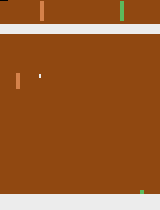